In [1]:
import numpy
import time
import pickle
import operator
from __future__ import print_function
from IPython.display import display
import matplotlib.pyplot as plt
import plotly.plotly as py
%matplotlib inline  

In [2]:

def load_file(filepath):
    """Reads a file into a list of phrases. Each phrase in the file must be separated with a new line character '\n' 
    Args:
        filepath (str): the relevant filepath of the file
    Returns:
        phrases (list(str)): A list with all the phrases 
    """
    with open(filepath, 'r') as f:
        phrases = f.readlines()
    return phrases

src_file = load_file('data/file.de')
trg_file = load_file('data/file.en')
aligned_file = load_file('data/file.aligned')



## Extract phrases and count orientations

In [3]:


def add_freq_dict(dictionary, key, value):
    """Increases the frequency of an phrase/item in the dictionary by 1, or adds it with a frequency of 1 if it doesn't exist yet
    Args:
        dictionary (dict): a dictionary that holds the frequency of an a phrase (item)
        item (str): a string whose frequency will be increased
    """
    if key in dictionary:
            dictionary[key][0] = [x+y for x,y in zip(dictionary[key][0] , value[0])]
            dictionary[key][1] = [x+y for x,y in zip(dictionary[key][1] , value[1])]
            dictionary[key][2] = [x+y for x,y in zip(dictionary[key][2] , value[2])]
            dictionary[key][3] = [x+y for x,y in zip(dictionary[key][3] , value[3])]
            dictionary[key][4] += 1
    else:
        dictionary[key] = value
        dictionary[key].append(1)

def extract(trg_start, trg_end, src_start, src_end, alignments, trg_aligned, trg_len):    
    """ Checks if the subphrases of the source and target language are a consistent pair, 
        assuming that no word in the source language is aligned with a word of the target language  outside the boundaries
    Args:
        trg_start (int): The target subphrase's first word position
        trg_end (int): The target subphrase's last word position
        src_start (int): The source subphrase's first word position
        src_end (int): The source subphrase's last word position
        alignments (list(tuple(int))): The alignment between the 
        trg_aligned (set(str)): A set with all the target language words that are aligned with at least one source word 
        trg_len (int): The number of words of the target language phrase
        
    Returns:
        E (list(tuple(str))): A list with all of the extracted phrase pairs (f,e). This is the base (f,e) specified by the arguement and pairs that have a words appended on 'e' that are unaligned 
        A (list(list(tuple(int)))): A list with the alignment of the respective pair at E (A[i] has the alignments of E[i]) 

    """
    if trg_end < 0 :
        return [], []
    
    A = []
    
    a = []
    
    for trg_word, src_word  in alignments:
        if trg_start <= trg_word <= trg_end:
            
            if (src_word < src_start or src_word > src_end):  
                return [], []
            else:
                
                a.append((trg_word - trg_start, src_word - src_start))

    E = []
    trg_s = trg_start
    
    while True:
        trg_e = trg_end
        while True:
            E.append([src_start, src_end, trg_s, trg_e])
            
            A.append(a)
             
            return E, A
        
            trg_e += 1
            
            if trg_e in trg_aligned or trg_e == len(trg_words):
                break 

        trg_s -= 1
        
        if trg_s in trg_aligned or trg_s < 0:
            break
            
        # if an unaligned word was added at the beginning, increase the alignments positions by 1 
       
        a = [(i[0]+1,i[1]) for i in a]
        
    return E, A


def extract_phrases(src_words, trg_words, alignments, cutoff):
    """
    Args:
        src_words (list(str)):
        trg_words (list(str)):
        alignments (list(tuple(int))):
        cutoff (int): 
        
    Returns:
        extracted_phrases (list(tuple(str))):
        extracted_alignments (list(tuple(int))):
    """
    
    if cutoff == -1:
        cutoff = len(src_words)
        
        
    trg_aligned = set()
    for (trg,_) in alignments:
        trg_aligned.add(trg)
    
    
    extracted_phrases = []
    extracted_alignments = []
    # for every possible 
    for src_start in range(len(src_words)):
        for src_end in range(src_start, min(src_start + cutoff, len(src_words))):

            #Find the min and max position of the target words that the source phrase is aligned to
            trg_start = len(trg_words) - 1
            trg_end = - 1
            for  (trg,src) in alignments: 
                if src_start <= src <= src_end:
                    trg_start = min(trg, trg_start)
                    trg_end = max(trg, trg_end)
                    
            
            if(trg_end - trg_start > cutoff - 1):
                continue

            phrase_pairs, A = extract(trg_start, trg_end, src_start, src_end, alignments, trg_aligned, len(trg_words))
            
            if (phrase_pairs):
                extracted_phrases.extend(phrase_pairs)
                for a in A:
                    extracted_alignments.append(a);
            
    return extracted_phrases, extracted_alignments





def count_reorderings(src_words, trg_words, A, word_based = False, phrase_cutoff = 7, distance_limit = 7):
    
    phrase_pairs_list = []
    
    pp, _ = extract_phrases(src_words, trg_words, A, phrase_cutoff)

    
    if word_based:
        next_iterator = A
    else:
        next_iterator = pp
    
    
    for phrase1  in pp:
        [src_s, src_e, trg_s, trg_e] = phrase1
        
        m, s, dr, dl = 0,0,0,0
        m2, s2, dr2, dl2 = 0,0,0,0
        distances, distances2 = [0]*(2*distance_limit) , [0]*(2*distance_limit)
        
       
        for a in next_iterator:
            
            if word_based:
                [next_src_s, next_src_e, next_trg_s, next_trg_e] = [a[1], a[1], a[0], a[0]]
            else:
                [next_src_s, next_src_e, next_trg_s, next_trg_e] = a
                

            # left to right
            #if it is the next word, check if monotone/swap/discontinues to the right
            if next_trg_s == trg_e + 1:
                if next_src_s == src_e + 1:
                    m+=1
                    distances[len(distances)/2] += 1
                elif src_s == next_src_e + 1:
                    s+=1
                    distances[len(distances)/2-1] += 1
                else: 
                    if next_src_s > src_e:
                        dr += 1
                        if(next_src_s - src_e <= distance_limit):
                            distances[len(distances)/2 + (next_src_s - src_e) - 1] += 1
                    elif next_src_e < src_s:
                        dl +=1
                            
                        if(src_s - next_src_e <= distance_limit):
                            distances[len(distances)/2 - (src_s - next_src_e)] += 1

            # right to left 
             #if it is the next word, check if monotone/swap/discontinues to the right
            if  next_trg_e == trg_s - 1:
                if next_src_e == src_s - 1:
                    m2+=1
                    distances2[len(distances)/2] += 1
                elif next_src_s == src_e + 1:
                    s2+=1
                    distances2[len(distances)/2-1] += 1
                else:
                    if next_src_s > src_e:
                        dl2 += 1
                        if (next_src_s - src_e <= distance_limit):
                            distances2[len(distances)/2 - (next_src_s - src_e)] += 1
                    elif next_src_e < src_s:
                        dr2 += 1
                        if (src_s - next_src_e <= distance_limit):
                            distances2[len(distances)/2 + (src_s - next_src_e) - 1] += 1

        pair = (" ".join(trg_words[trg_s:trg_e+1]) , " ".join(src_words[src_s:src_e+1]))        

        
        phrase_pairs_list.append((pair, [[m,s,dr,dl] , [m2,s2,dr2,dl2], distances, distances2]))
         

    
    return phrase_pairs_list






In [13]:
phrase_cutoff = 7;
distance_limit = 7;
word_based = True;


phrase_pairs = dict() 

start_time = time.time()
    
for i in range(len(src_file)):
    src_words = src_file[i].split()
    trg_words = trg_file[i].split()        
    alignments = [[int(a) for a in alignment.split('-')] for alignment in aligned_file[i].split()] #convert to list of int pairs
    alignments = [(al[1], al[0]) for al in alignments] #reverse their order so that they are (trg,src) instead of (src,trg)
    
    this_phrase_pairs = count_reorderings(src_words, trg_words, alignments, word_based, phrase_cutoff, distance_limit)
    
    for (key,value) in this_phrase_pairs:
        add_freq_dict(phrase_pairs, key, value)
        
    #show real time progress
    if ((i+1) % (len(src_file) / 100) == 0):
        print(' \r%d / %d (%ds)'%(i+1,len(src_file), time.time() - start_time), end = '')

print()
print('Done!!!')
print('Total duration: %ds'%(time.time() - start_time)) 

print("#unique en phrases: %d"%(len(phrase_pairs)))

for key in phrase_pairs.keys()[10:15]:
    print(key)
    print(phrase_pairs[key])
    print()

50000 / 50000 (135s)                                                                                               
Done!!!
Total duration: 135s
#unique en phrases: 2277463
('in its relations with the', 'in seinen beziehungen zu den')
[[0, 0, 2, 0], [0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 1]

('be tackled separately', 'gesonderter form durchgef\xc3\xbchrt werden')
[[0, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], 1]

('other relevant', 'weitere zweckm\xc3\xa4\xc3\x9fige')
[[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 1]

('even', 'auch dann')
[[0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 1]

('a strong voice in', 'einer starken stimme in')
[[1, 0, 0, 0], [1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0

## Convert counts/frequencies to probabilities

In [14]:
#convert counts to probabilities
for key, value in phrase_pairs.items():
    
    sum_ = numpy.sum(value[0])
    if sum_ > 0:
        for i in range(4):
            phrase_pairs[key][0][i] /= 1.0 * sum_

    sum_ = numpy.sum(value[1])
    if sum_ > 0:
        for i in range(4):
            phrase_pairs[key][1][i] /= 1.0* sum_
            
            

for key in phrase_pairs.keys()[10:15]:
    print(key)
    print(phrase_pairs[key])
    print()

('in its relations with the', 'in seinen beziehungen zu den')
[[0.0, 0.0, 1.0, 0.0], [0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 1]

('be tackled separately', 'gesonderter form durchgef\xc3\xbchrt werden')
[[0, 0, 0, 0], [0.0, 1.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], 1]

('other relevant', 'weitere zweckm\xc3\xa4\xc3\x9fige')
[[1.0, 0.0, 0.0, 0.0], [0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 1]

('even', 'auch dann')
[[0, 0, 0, 0], [0.0, 0.0, 0.0, 1.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 1]

('a strong voice in', 'einer starken stimme in')
[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], 1]



## Print the output files

In [15]:
sorted_pairs = sorted(phrase_pairs.keys(), key=operator.itemgetter(1), reverse = False)
output_folder = 'C:/Users/Thanos/Desktop/outputs/'

In [16]:
c = 0
start_time = time.time();

if word_based:
    filename = 'word_reorderings.txt'
else:
    filename = 'phrase_reorderings.txt'
    
    

with open(output_folder + filename, 'w') as the_file:
    for pair in sorted_pairs: 
        f = pair[1]
        e = pair[0]
        
        the_file.write('%s ||| %s ||| %f %f %f %f ||| %f %f %f %f \n' % (f, e, 
                                                                         phrase_pairs[pair][0][0], 
                                                                         phrase_pairs[pair][0][1], 
                                                                         phrase_pairs[pair][0][3], 
                                                                         phrase_pairs[pair][0][2], 
                                                                         phrase_pairs[pair][1][0], 
                                                                         phrase_pairs[pair][1][1], 
                                                                         phrase_pairs[pair][1][3], 
                                                                         phrase_pairs[pair][1][2]))

        if  c % (len(phrase_pairs) / 100) == 0: 
            print(' \r%d / %d (%d%%) (%ds)'%(c,len(sorted_pairs), 100 * c / len(sorted_pairs),time.time() - start_time), end = '')
        c +=1

print("\nDone!!!")

2277400 / 2277463 (99%) (10s)                                   
Done!!!


## Count reorderings and counts captured by phrases internally (uncomment to run)

In [25]:
# phrase_pairs = dict() 

# start_time = time.time()
    
# for i in range(len(src_file)):
#     src_words = src_file[i].split()
#     trg_words = trg_file[i].split()        
#     alignments = [[int(a) for a in alignment.split('-')] for alignment in aligned_file[i].split()] #convert to list of int pairs
#     alignments = [(al[1], al[0]) for al in alignments] #reverse their order so that they are (trg,src) instead of (src,trg)
    
#     pp, pp_a = extract_phrases(src_words, trg_words, alignments, 7)
    
#     for (phrase, phrase_alignments) in zip(pp,pp_a):
#         phrase_src_words = src_words[phrase[0] : phrase[1] + 1]
#         phrase_trg_words = trg_words[phrase[2] : phrase[3] + 1]
        
#         this_phrase_pairs = count_reorderings(phrase_src_words, phrase_trg_words, phrase_alignments, word_based = False)
    
#         for key,value in this_phrase_pairs.items():
#             add_freq_dict(phrase_pairs, key, value)

#     #show real time progress
#     if ((i+1) % (len(src_file) / 100) == 0):
#         print(' \r%d / %d (%ds)'%(i+1,len(src_file), time.time() - start_time), end = '')

# print()
# print('Done!!!')
# print('Total duration: %ds'%(time.time() - start_time))

# print("#unique en phrases: %d"%(len(phrase_pairs)))

# for key in phrase_pairs.keys()[10:15]:
#     print(key)
#     print(phrase_pairs[key])
#     print()

50000 / 50000 (267s)                                                                                               
Done!!!
Total duration: 267s
#unique en phrases: 2277463


## Average Variance or standard deviation of reorderings

 ------------------------------------- 
|       Left-to-Right |  mean |  std  |
|-------------------------------------|
|            Monotone | 0.513 | 0.483 |
|                Swap | 0.013 | 0.108 |
|          Disc-right | 0.265 | 0.422 |
|           Disc-left | 0.060 | 0.233 |
 ------------------------------------- 


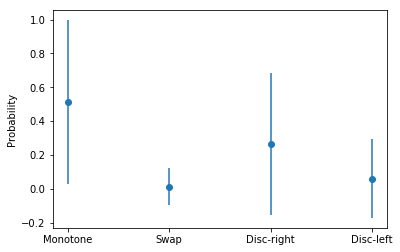

 ------------------------------------- 
|       Right-to-Left |  mean |  std  |
|-------------------------------------|
|            Monotone | 0.536 | 0.483 |
|                Swap | 0.021 | 0.138 |
|          Disc-right | 0.206 | 0.387 |
|           Disc-left | 0.068 | 0.245 |
 ------------------------------------- 


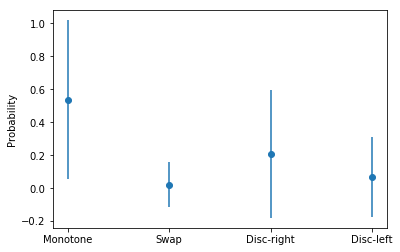

In [24]:
orientation = 0

reordering_names = ['Monotone', 'Swap', 'Disc-right', 'Disc-left']

for orientation in [0,1]:
    
    if orientation == 0: 
        print(" ------------------------------------- ")
        print("|%20s |  mean |  std  |"%('Left-to-Right') )
        print("|-------------------------------------|")
    else:
        print(" ------------------------------------- ")
        print("|%20s |  mean |  std  |"%('Right-to-Left') )
        print("|-------------------------------------|")
    
    all_means = []
    all_stds = []
    for reordering_type in range(4):
        X = [phrase_pairs[key][orientation][reordering_type] for key in phrase_pairs]
        
        for number in X:
            if number < 0:
                print(number)
        mean = numpy.mean(X)
        std = numpy.std(X)
        
        all_means.append(mean)
        all_stds.append(std)
        
        print("|%20s | %.3f | %.3f |" % (reordering_names[reordering_type], mean, std))
        
    
    print(" ------------------------------------- ")
    
    
#     plt.bar(range(4), all_means, align='center')
    
    plt.errorbar(range(4), all_means, all_stds, linestyle='None', marker='o')
    plt.ylabel('Probability')
    plt.xticks(range(4),reordering_names)
    plt.show()
    
    
    

## Phrase length analysis

            Monotone: ['0.371', '0.560', '0.607', '0.632', '0.646', '0.656', '0.667']
                Swap: ['0.045', '0.025', '0.016', '0.011', '0.008', '0.006', '0.005']
 Discontinuous-right: ['0.223', '0.191', '0.179', '0.171', '0.164', '0.156', '0.147']
  Discontinuous-left: ['0.136', '0.066', '0.043', '0.031', '0.024', '0.020', '0.017']


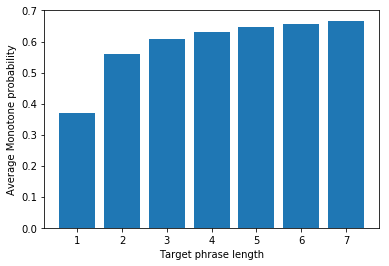

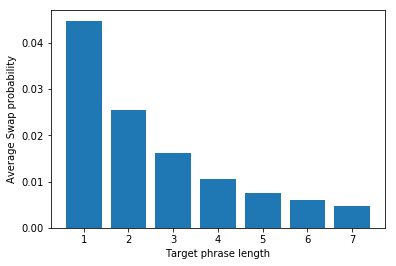

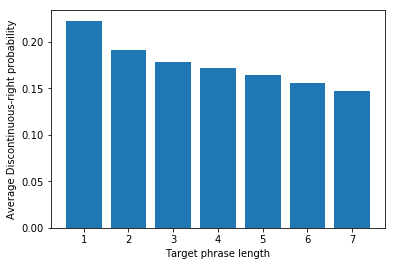

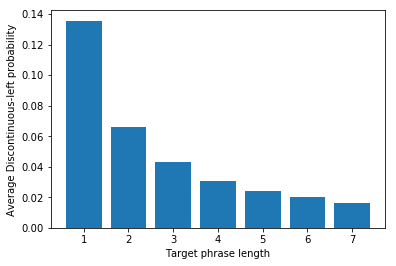

In [7]:
length_counters = [0] * phrase_cutoff
reordering_probabilities = [[0] * phrase_cutoff for i in range(4)]
    
reordering_names = ['Monotone', 'Swap', 'Discontinuous-right', 'Discontinuous-left']

orientation = 0

for phrase, value in phrase_pairs.items():
    
    trg_phrase_length = len(phrase[0].split())
    
    length_counters[trg_phrase_length - 1] += 1
    
    for reordering_type in range(4):
        reordering_probabilities[reordering_type][trg_phrase_length - 1] += value[orientation][reordering_type]
        

for j in range(4):
    for i in range(phrase_cutoff):
        reordering_probabilities[j][i] /= length_counters[i]
        
    print("%20s:"%reordering_names[j], ["{0:0.3f}".format(i) for i in reordering_probabilities[j]])#
    
    
 

for i in range(4):
    plt.bar(range(phrase_cutoff), reordering_probabilities[i], align='center')
    plt.xlabel('Target phrase length')
    plt.xticks(range(phrase_cutoff), range(1,phrase_cutoff + 1))
    plt.ylabel('Average %s probability' % reordering_names[i])
    if orientation == 0:
        plt.savefig('%s_length_lr.png' % reordering_names[i])
    else:
        plt.savefig('%s_length_rl.png' % reordering_names[i])
    plt.show()
   
    

## Phrase frequency analysis

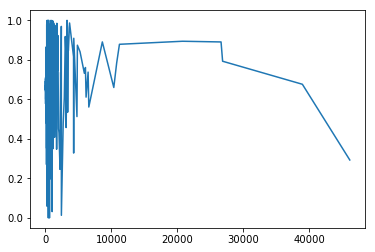

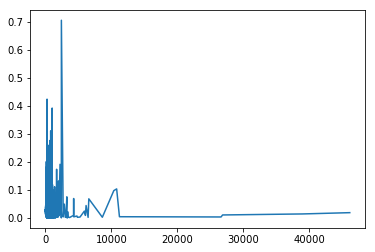

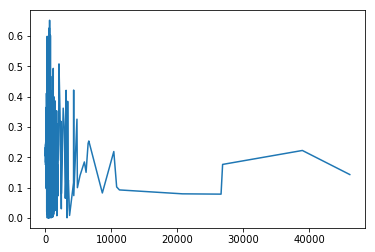

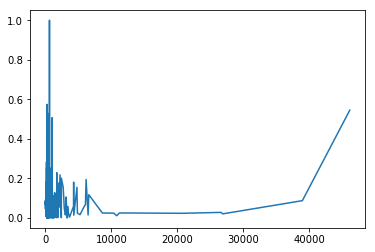

In [134]:
freq2reorderings = {}
freq2counts = {}

for phrase, value in phrase_pairs.items():
    
    freq = value[-1]
    
    if freq in freq2reorderings:
        freq2counts[freq] += 1
        freq2reorderings[freq] = [x+y for x,y in zip(freq2reorderings[freq] , value[0])]
    else:  
        freq2counts[freq] = 1
        freq2reorderings[freq] = value[0]
        
for freq, reorderings_probs in freq2reorderings.items():
    freq2reorderings[freq] = [reorderings_probs[i] / freq2counts[freq] for i in range(4)]
    
    
    

for reordering_type in range(4):
    
    X = sorted(freq2reorderings.keys())
    Y = [freq2reorderings[freq][reordering_type] for freq in X]
    
    plt.plot(X,Y) 
    plt.xlabel('Target phrase frequency') 
    plt.ylabel('Average %s probability' % reordering_names[i]) 
    plt.show()
        